# Plot some example Flux Curves
(notice that some are missing points)

51295


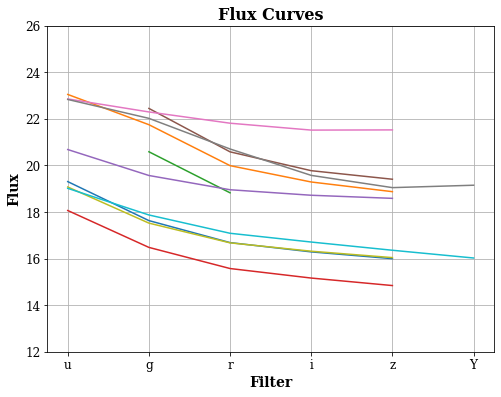

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the data from CSV
data = pd.read_csv('data/specz_fluxes.csv')
data = data.sort_values(by='spec_z')
data.reset_index(drop=True, inplace=True)

# Replace inf values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna(subset=['res'])

print(len(data))

random_array = np.random.randint(0, len(data), size=10)
random_rows = data.iloc[random_array]

column_names = ['u_cmodel_mag', 
                'g_cmodel_mag', 
                'r_cmodel_mag',
                'i_cmodel_mag',
                'z_cmodel_mag',
                'Y_cmodel_mag',]

selected_elements = random_rows.loc[:, column_names].values

# Plot the random fluxes
plt.figure(figsize=(8, 6),facecolor='white')

for element in selected_elements:
    plt.plot(range(len(column_names)), element)

plt.xlabel('Filter', fontsize=14, fontweight='bold')
plt.ylabel('Flux', fontsize=14, fontweight='bold')
plt.title(f'Flux Curves', fontsize=16, fontweight='bold')
plt.xticks(range(len(column_names)), ['u', 'g', 'r', 'i', 'z', 'Y'], fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(12,26)
plt.grid(True)

# Adjust font properties for better appearance
plt.rc('font', family='serif')
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=14)

plt.show()


# Cleaning (Generate Full Flux Curves)

In [43]:
import pandas as pd
from tqdm import tqdm

# Load the data from CSV
data = pd.read_csv('data/specz_fluxes.csv')
data = data.sort_values(by='spec_z')
data.reset_index(drop=True, inplace=True)

# Replace inf values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna(subset=['res'])

print(len(data))

filters = ['u_cmodel_mag', 'g_cmodel_mag','r_cmodel_mag', 'i_cmodel_mag','z_cmodel_mag', 'Y_cmodel_mag']
ferrors = ['u_cmodel_magerr', 'g_cmodel_magerr','r_cmodel_magerr', 'i_cmodel_magerr','z_cmodel_magerr', 'Y_cmodel_magerr']

data['interpolated'] = data[filters].isna().any(axis=1).astype(int)

# Iterate through each row and fill in missing fluxes
for index, row in tqdm(data.iterrows(), total=len(data), desc='Filling Empty Mag'):
    selected_row = row[filters].values  # Get the row values for the specified columns

    if np.sum(np.isnan(selected_row)) == 0:
        continue  # Skip if data is complete

    # Build from left
    left_build = np.copy(selected_row)
    for i in range(1, len(filters)):
        if not np.isnan(left_build[i - 1]) and np.isnan(left_build[i]):
            left_build[i] = left_build[i - 1] - avg_difference[i - 1]

    # Build from right
    right_build = np.copy(selected_row)
    for i in range(len(filters) - 2, -1, -1):
        if not np.isnan(right_build[i + 1]) and np.isnan(right_build[i]):
            right_build[i] = right_build[i + 1] + avg_difference[i]

    # Fill in gaps and then average
    left_build[np.isnan(left_build)] = right_build[np.isnan(left_build)]
    right_build[np.isnan(right_build)] = left_build[np.isnan(right_build)]
    full_build = (left_build + right_build) / 2

    # Update the row in the DataFrame
    data.loc[index, filters] = full_build

# Iterate through each row and fill in missing flux errors
for index, row in tqdm(data.iterrows(), total=len(data), desc='Filling Empty Magerr'):
    values = row[filters].values
    errors = row[ferrors].values

    if np.sum(np.isnan(errors)) == 0:
        continue  # Skip if data is complete

    # Fill missing errors based on values and avg_ratio
    full_error = np.copy(errors)
    for i in range(len(filters)):
        if np.isnan(full_error[i]):
            full_error[i] = values[i] * avg_ratio[i] if not np.isnan(values[i]) else np.nan

    # Update the row in the DataFrame
    data.loc[index, ferrors] = full_error
    
data.to_csv('data/clean_specz_fluxes.csv', index=False)  # This will save the DataFrame to 'filename.csv' without writing row indices


51295


filling empty magerr: 100%|█████████████| 51295/51295 [00:50<00:00, 1015.19it/s]


# Plot some Flux Curves
(Notice they are now complete)

51295


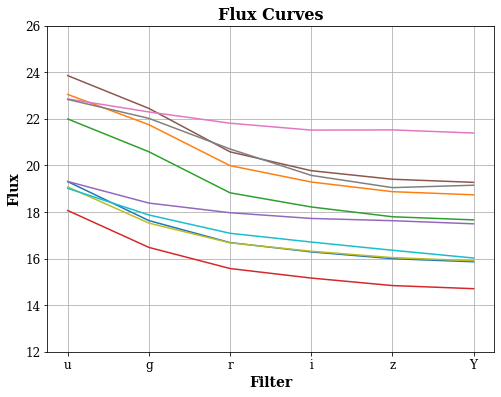

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the data from CSV
data = pd.read_csv('data/clean_specz_fluxes.csv')
data = data.sort_values(by='spec_z')
data.reset_index(drop=True, inplace=True)

print(len(data))

random_rows = data.iloc[random_array]

column_names = ['u_cmodel_mag', 
                'g_cmodel_mag', 
                'r_cmodel_mag',
                'i_cmodel_mag',
                'z_cmodel_mag',
                'Y_cmodel_mag',]

selected_elements = random_rows.loc[:, column_names].values

# Plot the random fluxes
plt.figure(figsize=(8, 6),facecolor='white')

for element in selected_elements:
    plt.plot(range(len(column_names)), element)

plt.xlabel('Filter', fontsize=14, fontweight='bold')
plt.ylabel('Flux', fontsize=14, fontweight='bold')
plt.title(f'Flux Curves', fontsize=16, fontweight='bold')
plt.xticks(range(len(column_names)), ['u', 'g', 'r', 'i', 'z', 'Y'], fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(12,26)
plt.grid(True)

# Adjust font properties for better appearance
plt.rc('font', family='serif')
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=14)

plt.show()


# Make synthetic data

In [54]:
data = pd.read_csv('data/clean_specz_fluxes.csv')

column_names = ['spec_z','res']+filters

# Function to generate new row of fluxes using the magerr as Gaussian noise
def generate_synthetic_row(row, errors):
    new_row = row.copy()
    for i, col in enumerate(filters):
        noise = np.random.normal(loc=0, scale=errors[i])
        new_row[col] += noise
    return new_row

# Generate new rows
new_rows = []

x=3
for _ in range(x):  # Iterate x times
    for index, row in tqdm(data.iterrows(), total=len(data), desc=f'Synthesizing New Data ({_+1}/{x})'):
        errors = row[ferrors].values
        new_row = generate_synthetic_row(row[column_names], errors)
        new_rows.append(new_row)

# Convert new rows to DataFrame
new_data = pd.DataFrame(new_rows, columns=column_names)

# Append new rows to the original DataFrame
synthetic_data = pd.concat([data[column_names], new_data], ignore_index=True)

print(len(synthetic_data))

synthetic_data.to_csv('data/synthetic_data.csv', index=False)  # This will save the DataFrame to 'filename.csv' without writing row indices


Synthesizing New Data (3/3): 100%|██████| 51295/51295 [00:21<00:00, 2382.55it/s]


205180
